# Vehicle Routing Problem with Heterogeneous Locker Boxes (VRPHLB)
## MILP Implementation and Solution using Gurobi

This notebook presents an implementation of the Vehicle Routing Problem with Heterogeneous Locker Boxes (VRPHLB) using Mixed-Integer Linear Programming (MILP). The goal is to minimize the total cost, including both the travel distance and compensation costs for locker box deliveries.

## Introduction

The Vehicle Routing Problem with Heterogeneous Locker Boxes (VRPHLB) is an extension of the classical Vehicle Routing Problem (VRP). In VRPHLB, parcels can be delivered to customers' homes or to locker boxes, which act as intermediate delivery points. This model aims to optimize the last-mile delivery process by incorporating alternative delivery points, enhancing logistic efficiency, and improving customer convenience.

## Key Components

- **Depot**: The starting and ending point for delivery vehicles.
- **Customers**: Each customer has a specific demand that needs to be delivered.
- **Locker Boxes**: Stations with slots of different sizes where parcels can be delivered and picked up by customers.

## Objectives

The primary objective is to minimize the total delivery cost, which includes:
- **Routing Cost**: The cost associated with the travel distance of vehicles.
- **Compensation Cost**: The cost incurred when parcels are delivered to locker boxes instead of directly to customers' homes.


# Mathematical Model

### Decision Variables

- $x_{ij}^v$: Binary variable indicating if vehicle $v$ travels directly from node $i$ to node $j$.
- $y_{ik}^v$: Binary variable indicating if customer $i$ is served at locker box station $k$ by vehicle $v$.
- $z_i^v$: Binary variable indicating if customer $i$ is served at home.
- $S_i$: Continuous variable for the service start time at node $i$.

### Objective Function

The objective is to minimize the total travel distance and compensation costs for using locker boxes :

$$
\min \sum_{i \in N} \sum_{j \in N} \sum_{v \in V} d_{ij} x_{ij}^v + \sum_{i \in N} \sum_{k \in B_i} \sum_{v \in V} c y_{ik}^v
$$

### Constraints

1. **Route Continuity**:
   Ensures that if a vehicle enters a node, it must leave the node:
$$
\sum_{j \in N \setminus \{i\}} x_{ij}^v = \sum_{j \in N \setminus \{i\}} x_{ji}^v \quad \forall i \in N, \forall v \in V
$$

2. **Vehicle Usage**:
   Ensures that each vehicle is used at most once:
$$
\sum_{j \in N \setminus \{0\}} x_{0j}^v \leq 1 \quad \forall v \in V
$$

3. **Customer Service**:
   Ensures that each customer is served either at home or at a locker box:
$$
\sum_{v \in V} \sum_{k \in B_i} y_{ik}^v + \sum_{v \in V} z_i^v = 1 \quad \forall i \in C
$$

4. **Locker Box Capacity**:
   Ensures that the total demand served at a locker box does not exceed its capacity:
$$
\sum_{i \in C} \sum_{v \in V} q_i y_{ik}^v \leq Q_k \quad \forall k \in B
$$

5. **Time Windows**:
    Ensures that the service starts within the specified time window:
$$
E_i \sum_{j \in N} \sum_{v \in V} x_{ij}^v \leq S_i \leq L_i \sum_{j \in N} \sum_{v \in V} x_{ij}^v \quad \forall i \in N
$$

6. **Service Time Continuity**:
    Ensures continuity in service times:
$$
S_i + s_i + d_{ij} - M(1 - x_{ij}^v) \leq S_j \quad \forall i, j \in N, \forall v \in V
$$


## Load and Visualize the GraphML Data

G has 41 nodes and 1640 edges


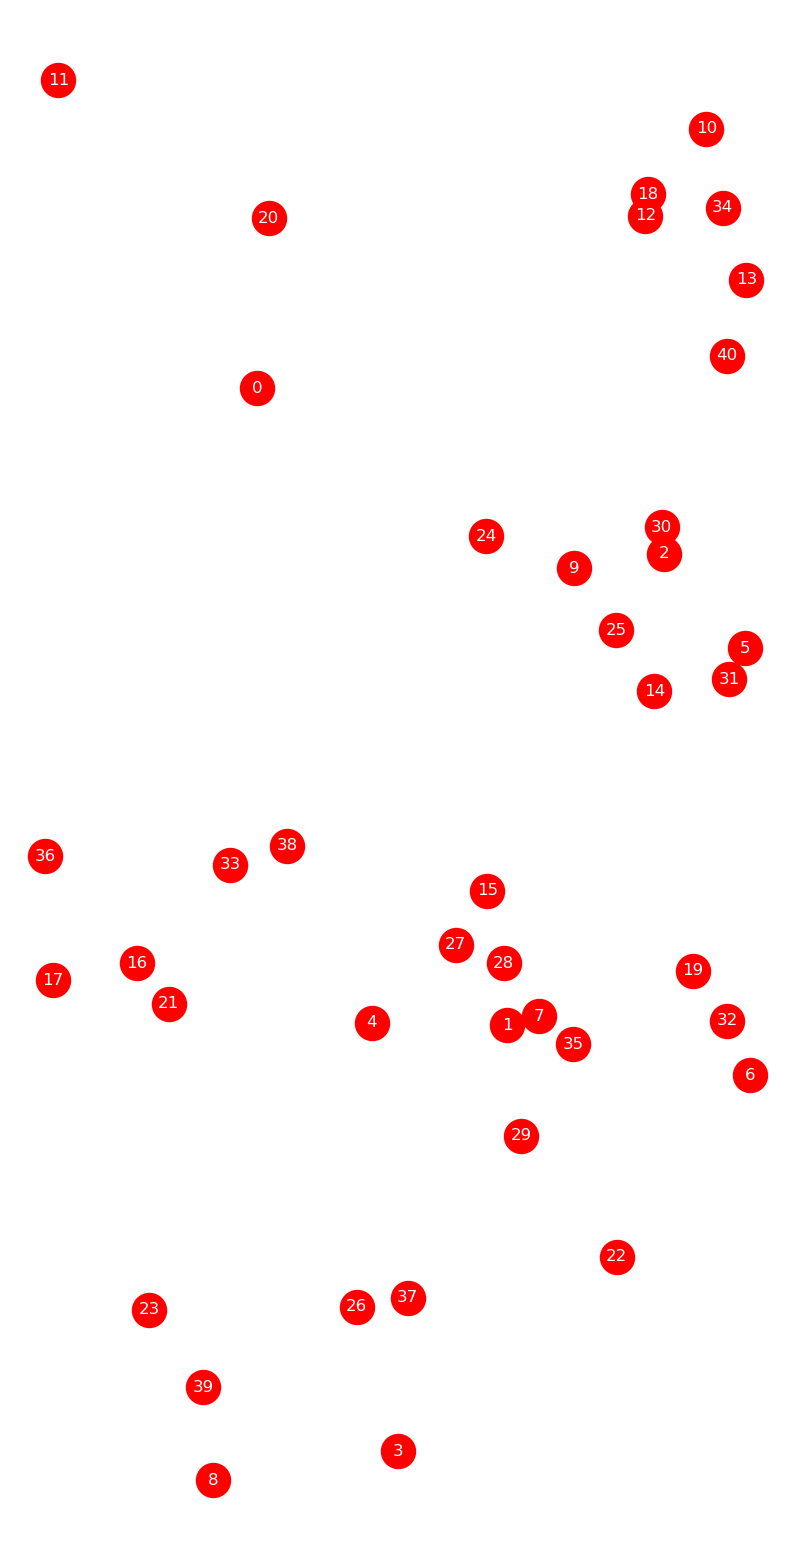

In [8]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import os

class args:
    filename = 'vrphlb_graph.graphml'
    scale = 50
    figsize = (10,10)
    
def DrawInitG(G, withedges=False):
    plt.figure(figsize=args.figsize)
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    if withedges:
        nx.draw_networkx_edges(G, pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    plt.figure(figsize=args.figsize)
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
    plt.axis('off')
    plt.show()

args.filename = "vrphlb_graph.graphml"
args.figsize = 10,20

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml(args.filename, node_type=int)

print("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G = nx.convert_node_labels_to_integers(G, first_label=0, label_attribute='old')

G.nodes(data=True)
pos = {i:(G.nodes[i]['x'] * args.scale, G.nodes[i]['y'] * args.scale) for i in G.nodes()}

DrawInitG(G)


## Extract Data and Define the VRPHLB Problem

In [9]:
# Extract nodes and edges
nodes = list(G.nodes(data=True))
edges = list(G.edges(data=True))

# Identify depot, customers, and locker boxes based on node attributes
depot = [n for n, attr in nodes if attr.get('type') == 'depot'][0]
customers = [n for n, attr in nodes if attr.get('type') == 'customer']
locker_boxes = [n for n, attr in nodes if attr.get('type') == 'locker']

# Extract distances from edges
distances = {(u, v): data['cost'] for u, v, data in edges}

# Define demands and capacities (assuming attributes are provided)
demands = {n: attr['demand'] for n, attr in nodes if 'demand' in attr}
capacities = {n: attr['capacity'] for n, attr in nodes if 'capacity' in attr}

# Define time windows
time_windows = {n: (attr['earliest'], attr['latest']) for n, attr in nodes if 'earliest' in attr and 'latest' in attr}

# Define the compensation cost
compensation_cost = 5  # Example value

# Display extracted data
print("Depot:", depot)
print("Customers:", customers)
print("Locker Boxes:", locker_boxes)
print("Distances:", distances)
print("Demands:", demands)
print("Capacities:", capacities)
print("Time Windows:", time_windows)
print("Compensation Cost:", compensation_cost)


Depot: 0
Customers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Locker Boxes: [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Distances: {(0, 1): 6.771918150067726, (0, 2): 2.411107086123297, (0, 3): 5.608649643855147, (0, 4): 5.418885737633308, (0, 5): 1.3817140562197419, (0, 6): 1.2795279453074206, (0, 7): 4.569586167391867, (0, 8): 2.2770875857472626, (0, 9): 2.625436874045328, (0, 10): 8.524879020013298, (0, 11): 9.433929669280685, (0, 12): 8.275466897129656, (0, 13): 1.3883770087385299, (0, 14): 9.716012727629447, (0, 15): 7.220679033596449, (0, 16): 5.408487603504765, (0, 17): 6.86367250009732, (0, 18): 8.039312525402302, (0, 19): 7.452357503504031, (0, 20): 2.9303215447867004, (0, 21): 5.6304754150292275, (0, 22): 9.24788990191333, (0, 23): 2.078647663027172, (0, 24): 5.482142438675572, (0, 25): 8.851542426241895, (0, 26): 9.876071692122213, (0, 27): 6.050717204725231, (0, 28): 7.629102638193372, (0, 29): 8.21040596283

## Implement the MILP Model Using Gurobi

In [10]:
import gurobipy as gp
from gurobipy import GRB

# Create model
model = gp.Model("VRPHLB")

# Decision variables
x = model.addVars(distances.keys(), vtype=GRB.BINARY, name="x")
y = model.addVars(customers, locker_boxes, vtype=GRB.BINARY, name="y")
z = model.addVars(customers, vtype=GRB.BINARY, name="z")
S = model.addVars(G.nodes(), vtype=GRB.CONTINUOUS, name="S")

# Objective function: minimize total travel distance + compensation costs
model.setObjective(gp.quicksum(distances[i, j] * x[i, j] for i, j in distances) +
                   gp.quicksum(compensation_cost * y[i, k] for i in customers for k in locker_boxes), GRB.MINIMIZE)

# Constraints
# Each customer is visited exactly once (either at home or locker box)
for i in customers:
    model.addConstr(gp.quicksum(x[i, j] for j in G.nodes() if j != i) +
                    gp.quicksum(y[i, k] for k in locker_boxes) == 1)

# Route continuity
for i in G.nodes():
    model.addConstr(gp.quicksum(x[i, j] for j in G.nodes() if j != i) ==
                    gp.quicksum(x[j, i] for j in G.nodes() if j != i))

# Locker box capacity constraints
for k in locker_boxes:
    model.addConstr(gp.quicksum(demands[i] * y[i, k] for i in customers) <= capacities[k])

# Time window constraints
for i, j in distances:
    if i != depot and j != depot:
        model.addConstr(S[i] + distances[i, j] - (1 - x[i, j]) * 1e5 <= S[j])

# Optimize model
model.optimize()

# Display solution
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    for i, j in distances:
        if x[i, j].X > 0.5:
            print(f"Route: {i} -> {j}")
    for i in customers:
        for k in locker_boxes:
            if y[i, k].X > 0.5:
                print(f"Customer {i} assigned to locker box {k}")
else:
    print("No optimal solution found.")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-04
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1641 rows, 2011 columns and 9760 nonzeros
Model fingerprint: 0xa4ce1bb2
Variable types: 41 continuous, 1970 integer (1970 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 150.0000000
Presolve removed 0 rows and 31 columns
Presolve time: 0.04s
Presolved: 1641 rows, 1980 columns, 9760 nonzeros
Variable types: 40 continuous, 1940 integer (1940 binary)

Root relaxation: objective 4.405903e+01, 125 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node  

## Visualize the Solution

C:\Users\adamb\AppData\Local\Temp\ipykernel_25096\232178322.py:46: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=pos,


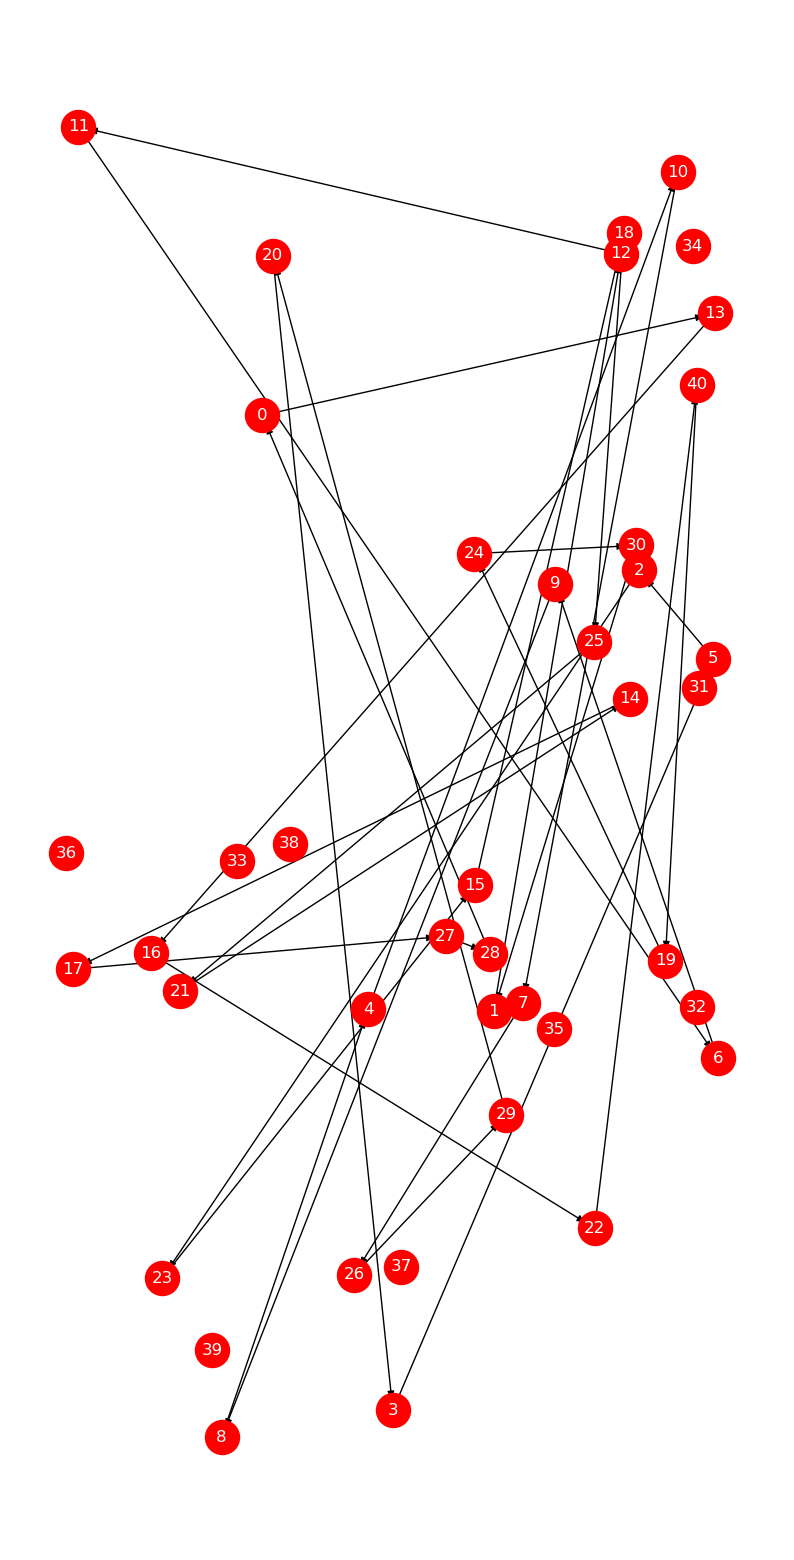

In [11]:
DrawSol(G,x)